In [17]:
import OffsetArrays
using Plots
using Revise
using StatsBase
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
using Distributions
srcpath = "../src"
include("$srcpath/bp.jl")
include("$srcpath/post_infer.jl")
include("$srcpath/observables.jl")

avg_ninf (generic function with 1 method)

In [18]:
function δλ(infer_lam)
    if infer_lam
        return 0.001im
    else
        return 0.0
    end
end

δλ (generic function with 1 method)

In [19]:
# S=0   I=1
# The times go from ti = 0 to ti=T+1
# when ti=0 it means that i is the zero patient
# when ti=T+1 it means that i is never infected

λp = 0.99# planted infection rate
λi = 0.99 #inferred infection rate

infer_lam = false #set it true if you want to infere the prior parameter λ
infer_gam = false #set it true if you want to infere the prior parameter γ


T = 8 # discrete time

γp = 0.01 # planted autoinfection probability
γi = 0.01 # inferred autoinfection probability

N = 20000; #population size
dilution = 0.0
fr = 0.0;


# Population dynamics for the messages

In [20]:
degree_dist = Dirac(3)
M = ParametricModel(N = N, T = T, γp = γp, λp = λp, γi=γi, λi=λi + δλ(infer_lam), fr=fr, dilution=dilution, distribution=degree_dist, field=1.0) ;

In [21]:
F,it = pop_dynamics(M, tot_iterations = 10, eta = 0.1, infer_lam=infer_lam, infer_gam=infer_gam);

([0.7612455412475341, -0.04423218345873247, 0.070390424121877, 0.09157591727349208, 0.09096645381306735, 0.08792690953530255, 0.09418976694610974, 0.12524882011459412, 0.08564657699381788, 0.09752350025302585], 10)

In [25]:
totiters = 30
Fr = []
field = LinRange(1.0,0.0,totiters)
it = zeros(totiters)
@showprogress for st = 1:totiters
    M.field = field[st]
    f_w, it[st] = pop_dynamics(M, tot_iterations = 40, eta = 0.1, infer_lam=infer_lam, infer_gam=infer_gam)
    Fr = [Fr;f_w]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:28:39


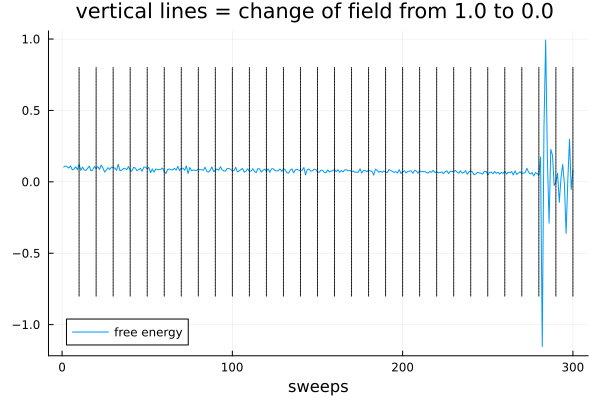

In [60]:
plot(Fr,xlabel="sweeps",label="free energy",title="vertical lines = change of field from 1.0 to 0.0 ")
plot!([fill(10*t,100) for t=1:30],LinRange(-0.8,0.8,100),linestyle=:dot,label=:false,color=:black)

In [83]:
M = ParametricModel(N = N, T = T, γp = γp, λp = λp, γi=γi, λi=λi + δλ(infer_lam), fr=fr, dilution=dilution, distribution=degree_dist, field=0.25) ;

In [ ]:
Fr = []
field = LinRange(0.25,0.0,totiters)
it = zeros(totiters)
Sr = zeros(totiters)
@showprogress for st = 1:totiters
    M.field = field[st]
    f_w, it[st] = pop_dynamics(M, tot_iterations = 40, eta = 0.1, infer_lam=infer_lam, infer_gam=infer_gam)
    Fr = [Fr;f_w]
    U = energy(M)
    Sr[st] = U - sum(f_w)/length(f_w)
end

Progress:   7%|██▊                                      |  ETA: 1:46:11

In [187]:
p0 = plot(LinRange(0.25,0.0,10 *totiters),Fr,xlabel="field",alpha=0.7,width=2,label="free energy",ylabel="Free Energy and Entropy")
#plot([fill(10*t,100) for t=1:30],LinRange(-0.5,0.5,100),linestyle=:dot,label=:false,color=:black)
p0 = scatter!(LinRange(0.25,0.0,totiters),xflip=true,c=:reds,Sr,markersize=4,ylim=(-0.35,0.35),legend=:topleft,label="entropy")
p0 = plot!(LinRange(0.25,0.0,totiters),fill(0,totiters),c=:grey,linestyle=:dot,label=false)
p0 = scatter!(twinx(),LinRange(0.25,0.0,totiters),it,xflip=true,marker=:diamond,c=:black,label="iterations",legend=(0.85,0.06),ylabel="Iterations")
plot(p0)
savefig("field.pdf")

"/home/students/mmariani/git/Epidemble/test/field.pdf"

In [450]:
marg = M.belief |> real;
margobs = reshape(sum(marg,dims=3) ./ N, T+2,T+2);

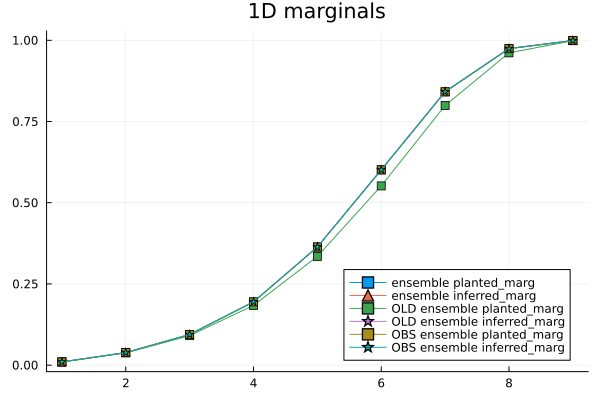

In [451]:
marg = M.belief |> real;
marg2D = reshape(sum(marg,dims=3) ./ N, T+2,T+2);
p0 = plot(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),marker=:square,label="ensemble planted_marg",title="1D marginals")
p0 = plot!(cumsum(sum(marg2D,dims=2)[1:end-1],dims=1),marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
p0 = plot!(cumsum(sum(margold,dims=1)'[1:end-1],dims=1),marker=:square,label="OLD ensemble planted_marg",title="1D marginals")
p0 = plot!(cumsum(sum(margold,dims=2)[1:end-1],dims=1),marker=:star,label="OLD ensemble inferred_marg",legend=:bottomright)
p0 = plot!(cumsum(sum(margobs,dims=1)'[1:end-1],dims=1),marker=:square,label="OBS ensemble planted_marg",title="1D marginals")
p0 = plot!(cumsum(sum(margobs,dims=2)[1:end-1],dims=1),marker=:star,label="OBS ensemble inferred_marg",legend=:bottomright)

In [349]:
margold = copy(marg2D)

10×10 Matrix{Float64}:
 9.75e-5      0.000278     0.0005325   …  0.000374     1.25e-5
 0.00028385   0.000809338  0.00155026     0.00108882   3.63911e-5
 0.000540231  0.00154035   0.00295049     0.00207227   6.92603e-5
 0.000984005  0.00280568   0.00537418     0.00377454   0.000126155
 0.00164344   0.00468591   0.0089757      0.00630406   0.000210697
 0.00231583   0.00660309   0.012648    …  0.00888329   0.000296901
 0.002351     0.00670336   0.0128401      0.00901819   0.00030141
 0.00129136   0.00368204   0.00705283     0.00495354   0.000165559
 0.000236412  0.000674077  0.00129117     0.000906851  3.03092e-5
 6.37097e-6   1.81654e-5   3.47953e-5     2.44384e-5   8.16791e-7

In [296]:
include("$srcpath/bp.jl")
include("$srcpath/post_infer.jl")
include("$srcpath/observables.jl")
ms = energy(M)

LoadError: InterruptException:

In [297]:
marg = M.belief |> real;
marg2D = reshape(sum(marg,dims=3) ./ N, T+2,T+2)
ensAUC = avgAUC(marg,M.obs_list,count_obs=true); #set false to see the AUC only on NON observed indiv.

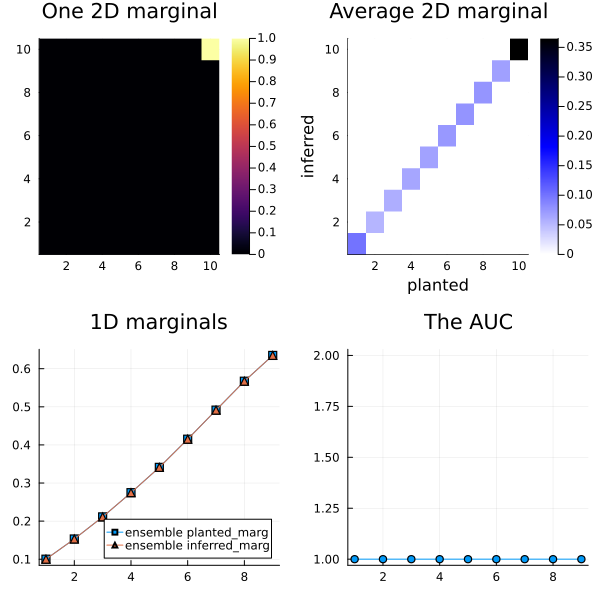

In [298]:
p1 = heatmap(reshape((marg[:,:,rand(1:N)]),T+2,T+2),title="One 2D marginal")
p2 = plot(ensAUC,label="ens_AUC",marker=:c,legend=false,title="The AUC")
pheat = heatmap((marg2D),c=[:white,:blue,:black],xlabel="planted",ylabel="inferred",title="Average 2D marginal")
p0 = plot(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),marker=:square,label="ensemble planted_marg",title="1D marginals")
p0 = plot!(cumsum(sum(marg2D,dims=2)[1:end-1],dims=1),marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
plot(p1,pheat,p0,p2,size=(600,600))

# Single Instance Inferernce with Sib

## General framework with disorder
Here the results of observations change because the parameter regime is non trivial. Therefore we need to sample a planted configuration, observe this configuration at final time and infere the single instance. We do this many times and we average so to compare with the ensemble results

### Check of the planted distribution
Here we check with a sampler and with sibyl that the planted ensemble marginal is correct.

In [51]:
include("$srcpath/single_instance.jl")

nontrivial_conn (generic function with 1 method)

In [462]:

Ngraph = 200000 # size of the single instance graph
x = zeros(Int,Ngraph, T + 1) # a single epidemic trajectory

# First we initialize a single instance marginal y
# which will be the average over graph and particles
# and epidemic trajectory of the marginals
y = zeros(T+1)
yBPp = zero(y)
# we average over totst iterations
totst = 1
@showprogress for st = 1:totst
    # for every iteration we initialize a new graph
    G = makeGraph(Ngraph,degree_dist)
    # we sample an epidemic
    sample!(x, G, λp, γp)
    # we calculate the cumulative marginal (non-normalized)
    # and we sum it to the average marginal
    y .+= sum(x,dims=1)'
    p_sib = sibyl(Ngraph, T+1, G, [], γp, λp; maxit = 40, tol = 1e-2);
    avgmarg = sum(p_sib,dims=1)' ./ Ngraph
    yBPp .+= avgmarg
end
#we normalize the average marginal
y ./= (Ngraph * totst)
yBPp ./=  totst;

LoadError: InterruptException:

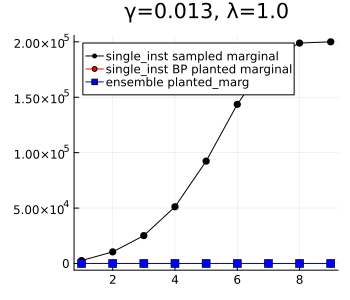

In [463]:
p0 = plot(y,c=:black,marker=:circle,label="single_inst sampled marginal",title="γ=$γp, λ=$λp")
p0 = plot!(yBPp,c=:red,marker=:circle,label="single_inst BP planted marginal")
p0 = plot!(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),c=:blue,marker=:square,size=(350,300),label="ensemble planted_marg",legend=:topleft)

### Comparison between inference (sibyl) and ensemble results
Here we check instead the results for the inferred marginal

In [464]:
yBP = zeros(T+1)
yBPerr = zero(yBP)
totst = 1
λinfer = zeros(totst)
γinfer = zeros(totst)
@showprogress for st = 1:totst
    # for every iteration we initialize a new graph
    G = makeGraph(Ngraph,degree_dist)
    # we sample an epidemic
    sample!(x, G, λp, γp)
    # observations set in the form of 
    # [(individual,state,observation time, false_rate of the test)]
    # where state ∈ {0,1} respectively for S and I
    # The reason why there is a T+1 is that sibyl starts from time 1 to time T. 
    # Instead the ensemble goes from time 0 to time T  
    O = [(i,Bool(x[i,T+1]),T+1,1e-10) for i = 1:Int(round(Ngraph * (1 - dilution)))]
    O = [rand() > fr ? (o[1],o[2],o[3],fr) : (o[1],!o[2],o[3],fr) for o in O]
    #we now run the BP algorithm for the single instance defined above
    p_sib = sibyl(Ngraph, T+1, G, O,  γi , λi; maxit = 200, tol = 1e-2);
    yBP .+= sum(p_sib,dims=1)'
    yBPerr .+= sum(p_sib ,dims=1)' .^ 2
end

yBP ./= (Ngraph * totst);
#yBPerr ./= (Ngraph^2 * totst)
#yBPerr .= sqrt.(yBPerr .- yBP .^ 2) / sqrt(totst)

LoadError: InterruptException:

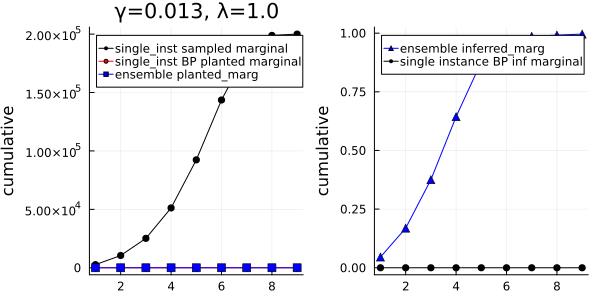

In [465]:
p1 = plot(cumsum(sum(marg2D,dims=2),dims=1)[1:end-1],c=:blue,marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
p1 = plot!(yBP,c=:black,marker=:circle,label="single instance BP inf marginal")
plot(p0,p1,size=(600,300),ylabel="cumulative",legend=:topleft)
#savefig("sibVSepid")

In [466]:
p2 = plot(yBP,c=:black,marker=:circle,label="single instance BP inf marginal")
p2 = plot!(yBPp,marker=:utriangle,label="single instance BP plant marginal")
p3 = plot(cumsum(sum(marg2D,dims=2),dims=1)[1:end-1],c=:black,marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
p3 = plot!(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),c=:blue,marker=:square,size=(350,300),label="ensemble planted_marg",legend=:topleft)
plot(p2,p3,ylim=(0,1))

LoadError: InterruptException:

## 2D marginal comparison

In [64]:
function pdf(cdf_sib)
    N, T = size(cdf_sib) 
    p = zeros(N,T+1)
    p[:,1] .= cdf_sib[:,1]
    for t = 1:T-1
        p[:,t+1] .= cdf_sib[:,t+1] .- cdf_sib[:,t]
    end
    p[:,T+1] .= 1 .- cdf_sib[:,T]
    return p
end

pdf (generic function with 1 method)

In [65]:
AUC = zeros(T+1)
AUCerr = zeros(T+1)
AUC =  zeros(T+1)
sibylmarg2D = zeros(T+2,T+2)
totst = 1
mse = 0
@showprogress for st = 1:totst
    G = makeGraph(Ngraph,degree_dist)
    sample!(x, G, λp, γp)
    O = [(i,Bool(x[i,T+1]),T+1,1e-10) for i = 1:Int(round(Ngraph * (1 - dilution)))]
    O = [rand() > fr ? (o[1],o[2],o[3],fr) : (o[1],!o[2],o[3],fr) for o in O]
    p_sib = sibyl(Ngraph, T+1, G, O, γi, λi; maxit = 40, tol = 1e-100);
    sib_pdf = pdf(p_sib)
    mse = siMSE(x, p_sib)
    for t = 1:T+1
        AUC[t] += AUROC(ROC(x[:,t], p_sib[:,t]))
        AUCerr[t] += AUROC(ROC(x[:,t], p_sib[:,t]))^2
    end
    tau = T .- sum(x,dims=2) .+ 2; #set of planted times
    for τ = 1:T+2
        # We take the pdf only for individuals infected at time τ 
        sibylmarg2D[:,τ] .+= sum(sib_pdf .* (tau .== τ ),dims=1)' 
    end
    sing_inst_marg = zeros(Ngraph, T+2, T+2)
    for l = 1:Ngraph
        sing_inst_marg[l,:,tau[l]] .= sib_pdf[l,:] 
    end
    sing_inst_marg = OffsetArrays.OffsetArray(sing_inst_marg,0,-1,-1);
    #AUCens = avgAUC(sing_inst_marg)
end
AUC ./= totst 
AUCerr .= sqrt.((AUCerr./ totst  .- (AUC .^ 2))./ totst ) 
sibylmarg2D ./= (Ngraph*totst);



sib.iterate(damp=0.0): 39/40 2.206e-06/1e-100      
sib.iterate(damp=0.5): 39/40 3.543e-09/1e-100      


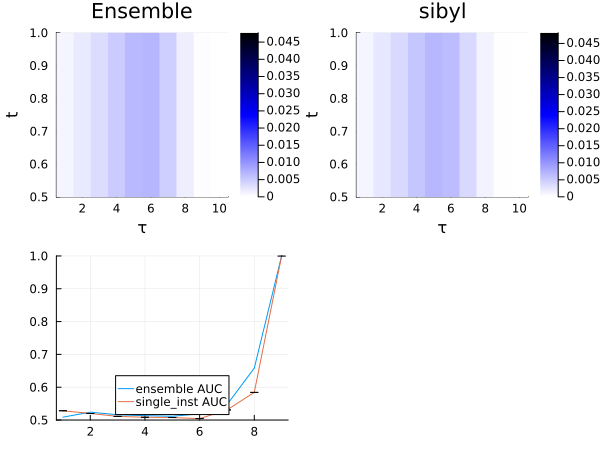

In [66]:
plot_sib = heatmap(sibylmarg2D,c=[:white,:blue,:black],xlabel="τ",ylabel="t",title="sibyl") 
plot_ens = heatmap(marg2D,c=[:white,:blue,:black],xlabel="τ",ylabel="t",title="Ensemble")
pAUC = plot(ensAUC,label="ensemble AUC")
#pAUC = plot(avgAUC(marg),label="ensemble AUC")
pAUC = plot!(AUC,label="single_inst AUC",legend=:topleft,yerr=AUCerr)
plot(plot_ens,plot_sib,pAUC,size = (600,450),ylims=(0.5,1.0),legend=:bottom)
#savefig("ensemble_VS_sibyl")

In [41]:
prova = SimpleGraph(1000)
add_edge!(prova,201,200)
collect(edges(prova))

1-element Vector{Graphs.SimpleGraphs.SimpleEdge{Int64}}:
 Edge 200 => 201

In [49]:
length(outedges(G,1))

3

In [10]:
include("$srcpath/single_instance.jl")
Ngraph = 10000000 # size of the single instance graph
x = zeros(Int,Ngraph, T + 1) # a single epidemic trajectory

G = makeGraph(Ngraph,degree_dist)
γRange = LinRange(0.001,0.025,100) 
nconn = zeros(100)
λp = 1.0
@showprogress for st = 1:100
    sample!(x, G, λp, γRange[st])
    nconn[st] = S_subgraph(G,x)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:18:57


In [11]:
using DelimitedFiles
open("./N=$(Ngraph)nconn.txt","w") do io
    writedlm(io,nconn) 
end

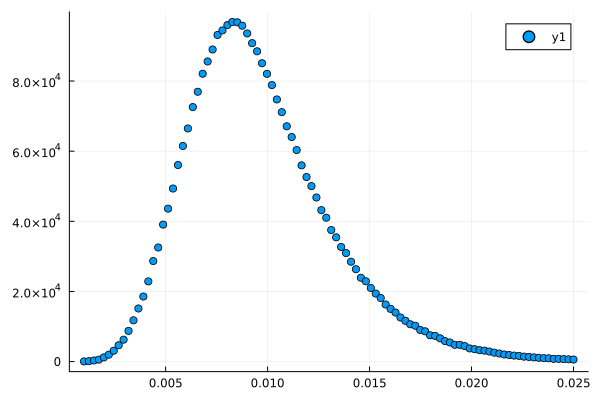

In [12]:
scatter(γRange,nconn)

# Hyperparameters Inference

# A study on variation of $\lambda$\lambda